# Environment Setup

In [ ]:
!git clone https://github.com/martintb/active_learning_tutorial

In [ ]:
%cd active_learning_tutorials

In [ ]:
!pip install -e . 

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sklearn.cluster
from sklearn.metrics import pairwise

from tutlib import *

# Introduction Challenge

In [183]:
inst1 = get_virtual_instrument1(noise=1e-9)

In [206]:
inst1.measure(a=0.6,b=0.2,c=0.2)

<xarray.Dataset>
Dimensions:   (q: 250, logq: 250)
Coordinates:
  * q         (q) float64 0.00396 0.004042 0.004125 ... 0.6082 0.6207 0.6335
  * logq      (logq) float64 -2.402 -2.393 -2.385 ... -0.216 -0.2071 -0.1983
Data variables:
    sas       (q) float64 2.647 2.648 2.649 2.651 2.652 ... 1.0 1.0 1.0 1.0 1.0
    log_sas   (logq) float64 0.4227 0.4229 0.4231 ... 1.59e-05 1.467e-05
    dlog_sas  (logq) float64 0.01569 0.01737 0.01904 ... 5.858e-05 0.0001019
    a         float64 0.6
    b         float64 0.2
    c         float64 0.2

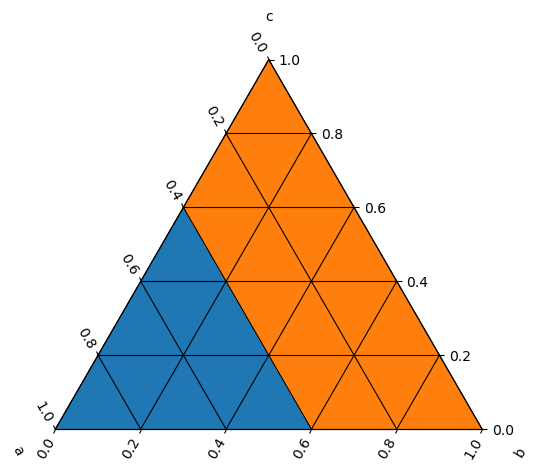

In [185]:
inst1._plot_ground_truth_data()

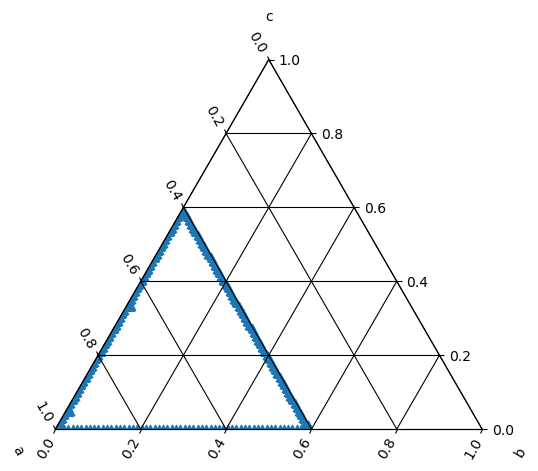

In [186]:
inst1._plot_ground_truth()

## Make Starting Dataset

In [207]:
composition_list = [
    {'a':1/3,'b':1/3,'c':1/3},
    {'a':0.6,'b':0.2,'c':0.2},
]

In [208]:
data_list = []
for comp in composition_list:
    dataset = inst1.measure(**comp)
    data_list.append(dataset)
input_dataset = xr.concat(data_list,dim='sample')
input_dataset

<xarray.Dataset>
Dimensions:   (q: 250, sample: 2, logq: 250)
Coordinates:
  * q         (q) float64 0.00396 0.004042 0.004125 ... 0.6082 0.6207 0.6335
  * logq      (logq) float64 -2.402 -2.393 -2.385 ... -0.216 -0.2071 -0.1983
Dimensions without coordinates: sample
Data variables:
    sas       (sample, q) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    log_sas   (sample, logq) float64 2.203e-07 1.648e-07 ... 1.59e-05 1.465e-05
    dlog_sas  (sample, logq) float64 -1.066e-06 -1.03e-06 ... 0.0001018
    a         (sample) float64 0.3333 0.6
    b         (sample) float64 0.3333 0.2
    c         (sample) float64 0.3333 0.2

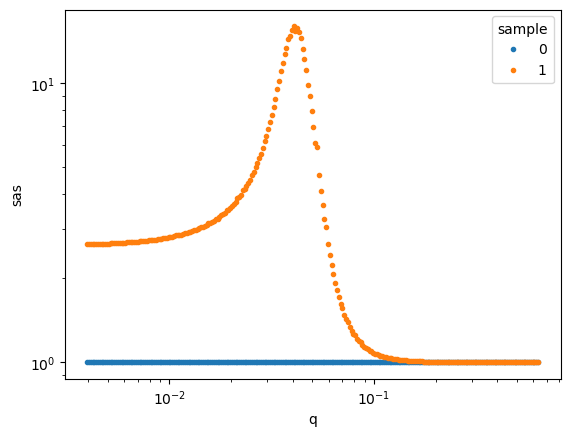

In [209]:
input_dataset.sas.plot.line(
    x='q',
    xscale='log',
    yscale='log',
    marker='.',
    ls='None',
)

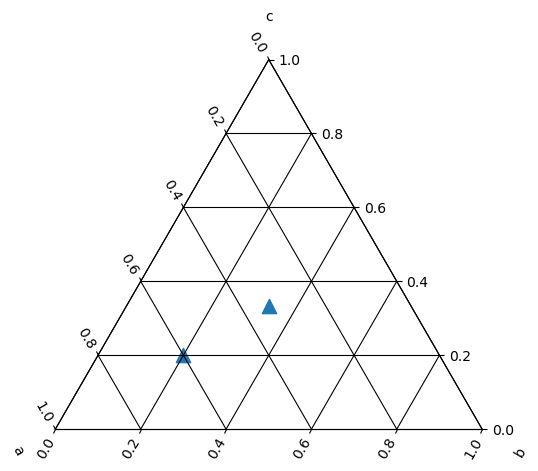

In [210]:
plot_ternary_scatter(input_dataset,components=['c','a','b'],s=105,clip_on=False)

## Configure Learning

In [211]:
def extrapolate(dataset):
    if dataset.attrs['n_phases']>1:
        with tf.device('CPU'):
            kernel=gpflow.kernels.Matern32(variance=0.5,lengthscales=1.0)
            GP = GaussianProcess.GP(dataset=dataset, kernel=kernel)
            GP.optimize(2000,progress_bar=False)
            
        result = GP.predict(dataset.attrs['components_grid'])
        dataset['gp_y_mean'] = (('grid','phase'),result['mean'])
        dataset['gp_y_var'] = (('grid','phase'),result['var'])
    else:
        dataset['gp_y_mean'] = (('grid','phase'),np.ones((dataset.sizes['grid'],1)))
        dataset['gp_y_var'] = (('grid','phase'),np.ones((dataset.sizes['grid'],1)))
            
    return dataset

In [212]:
def choose_next_acquisition(dataset):
    # choose function
    acquisition = dataset['gp_y_var'].sum('phase')
    dataset['acquisition'] = acquisition
    
    # get index max value
    next_sample_index = acquisition.assign_coords(grid=np.arange(acquisition.sizes['grid'])).idxmax().values[()]
    
    # "Thompson" sample
    #p=(acquisition-acquisition.min())/(acquisition.max()-acquisition.min())
    #next_sample_index = np.random.choice(acquisition.grid,p=p)
    
    # get composition associated with selection
    next_sample_comp = dataset[dataset.attrs['components_grid']].isel(grid=int(next_sample_index))
    
    next_sample_comp_dict = {k.replace('_grid',''):v for k,v in next_sample_comp.to_pandas().to_dict().items()}
    dataset.attrs['next_sample'] = next_sample_comp_dict
    
    return dataset

In [213]:
def label(dataset):
    X = dataset['dlog_sas'].squeeze().transpose('sample',...)
    
    #calculate similairity/affinity matrix for the scattering data
    W = pairwise.pairwise_kernels(
        X, 
        filter_params=True,  
        metric='laplacian',
        gamma=0.00025
    )
    
    clf = sklearn.cluster.SpectralClustering(
        n_clusters=2,
        affinity='precomputed',
    )
    clf.fit(W)
    
    #store results in the dataset
    dataset['labels'] = ('sample',clf.labels_)
    dataset['labels_ordinal'] = make_ordinal_labels(dataset['labels'])
    dataset.attrs['n_phases'] = len(np.unique(clf.labels_))
    return dataset

 
results = actively_learn(
    input_dataset=input_dataset,
    niter = 10,
    label=label,
    extrapolate=extrapolate,
    choose_next_acquisition=choose_next_acquisition,
    instrument=inst1,
)
                
display(results[-1])

  0%|                                                  | 0/10 [00:00<?, ?it/s]/Users/tbm/software/mambaforge/envs/afl_agent/lib/python3.8/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
100%|█████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


<xarray.Dataset>
Dimensions:         (q: 250, sample: 11, logq: 250, grid: 5050, phase: 2)
Coordinates:
  * q               (q) float64 0.00396 0.004042 0.004125 ... 0.6207 0.6335
  * logq            (logq) float64 -2.402 -2.393 -2.385 ... -0.2071 -0.1983
Dimensions without coordinates: sample, grid, phase
Data variables: (12/14)
    sas             (sample, q) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    log_sas         (sample, logq) float64 2.203e-07 1.648e-07 ... 1.466e-05
    dlog_sas        (sample, logq) float64 -1.066e-06 -1.03e-06 ... 0.0001018
    a               (sample) float64 0.3333 0.6 0.4646 ... 0.3838 0.4444 0.4545
    b               (sample) float64 0.3333 0.2 0.1414 ... 0.3838 0.2626 0.07071
    c               (sample) float64 0.3333 0.2 0.3939 ... 0.2323 0.2929 0.4747
    ...              ...
    c_grid          (grid) float64 1.0 0.9899 0.9798 0.9697 ... 0.0101 0.0 0.0
    labels          (sample) int32 1 0 0 1 0 1 1 1 1 0 0
    labels_ordinal  (sample) float64 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0
    gp_y_mean       (grid, phase) float64 0.1649 0.8351 0.1536 ... 0.7042 0.2958
    gp_y_var        (grid, phase) float64 0.1377 0.1377 0.13 ... 0.2083 0.2083
    acquisition     (grid) float64 0.2754 0.26 0.2442 ... 0.4107 0.4111 0.4166
Attributes:
    step:             9
    components:       ['c', 'a', 'b']
    components_grid:  ['c_grid', 'a_grid', 'b_grid']
    n_phases:         2
    next_sample:      {'c': 0.030303030303030276, 'a': 0.36363636363636365, '...

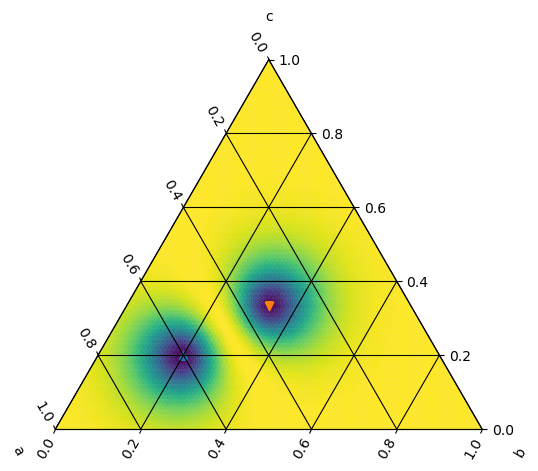

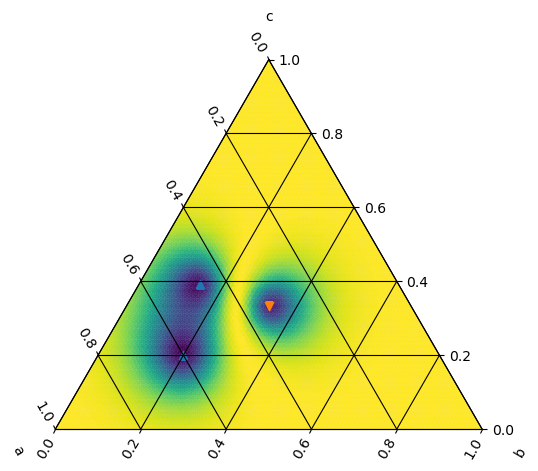

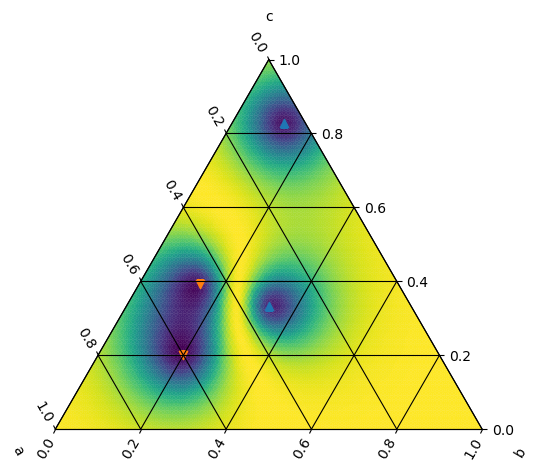

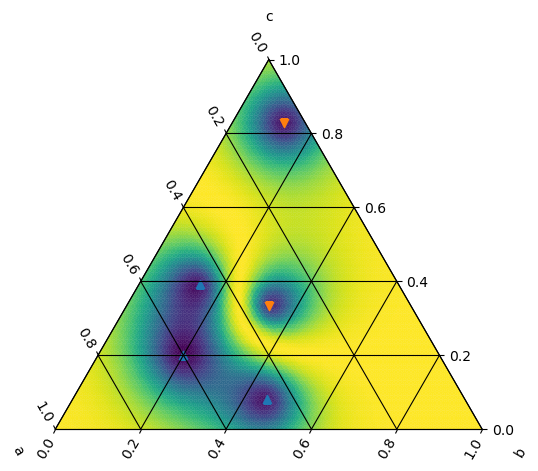

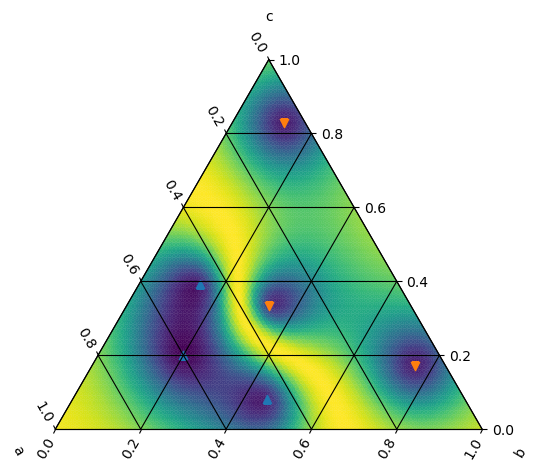

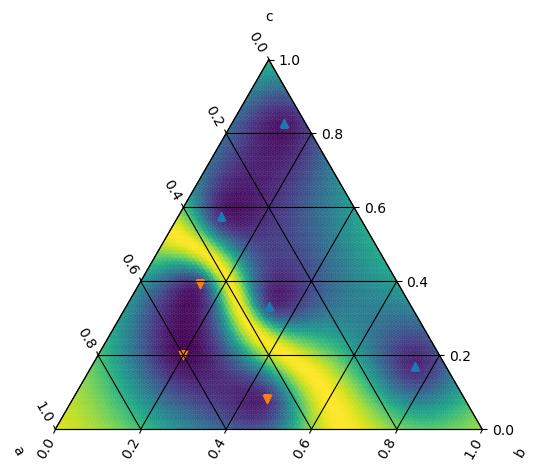

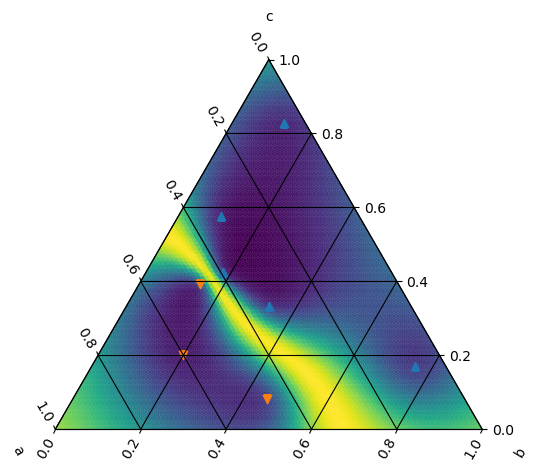

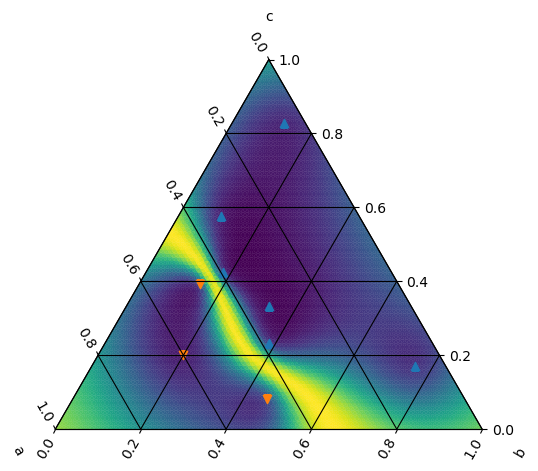

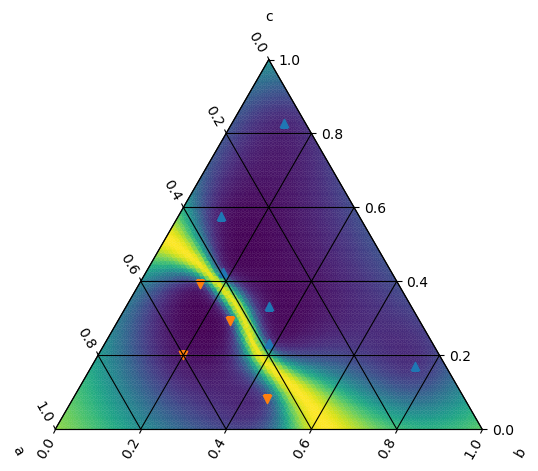

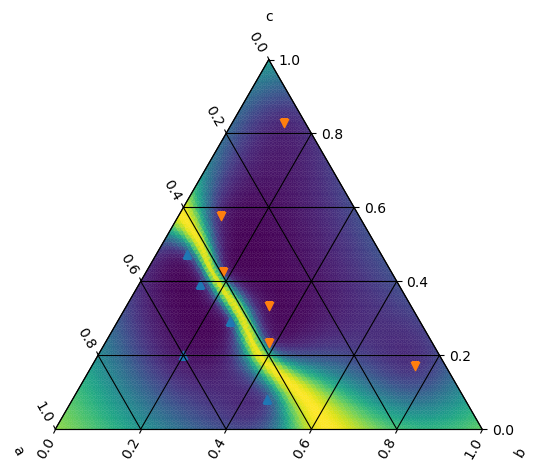

In [215]:
for result in results:
    result.afl.comp.plot_surface(['c_grid','a_grid','b_grid'],labels=result['gp_y_var'].sum('phase'))
    result.afl.comp.plot_scatter(['c','a','b'],ax=plt.gca())

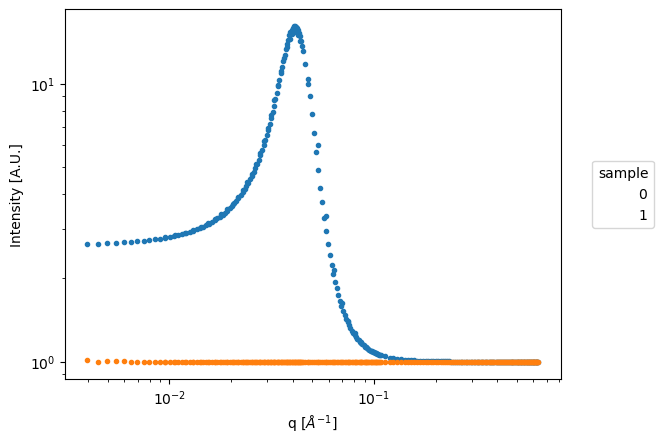

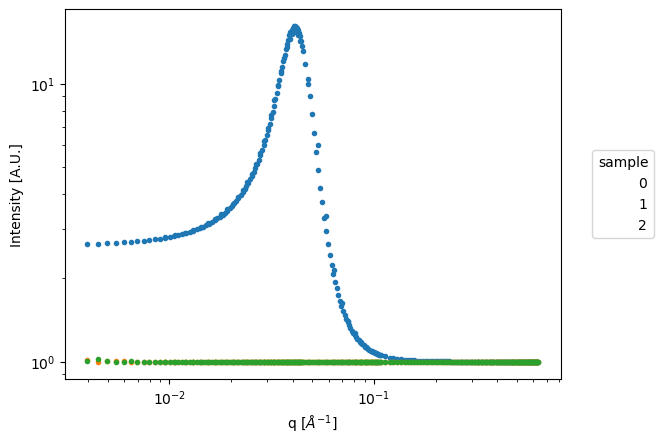

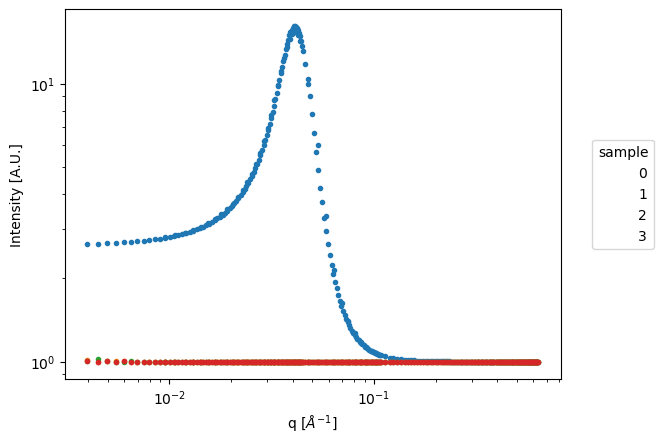

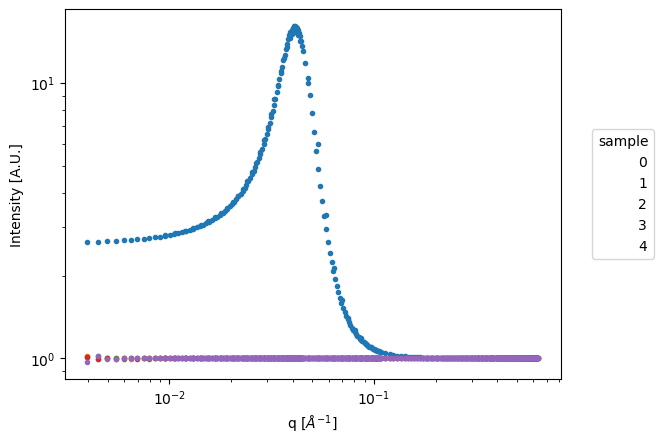

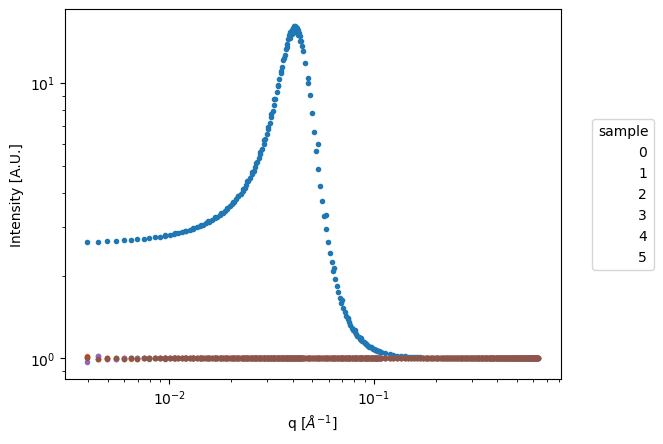

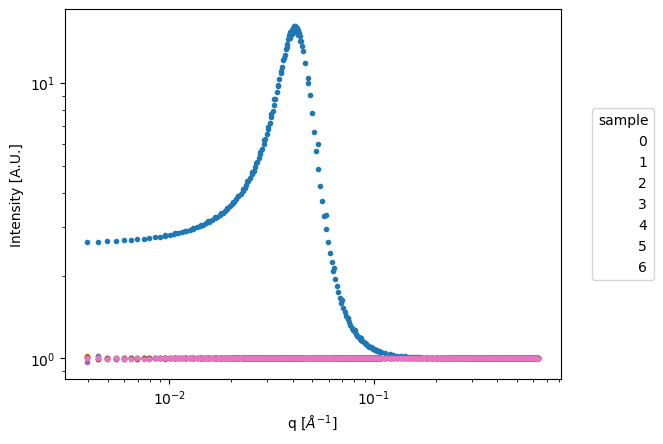

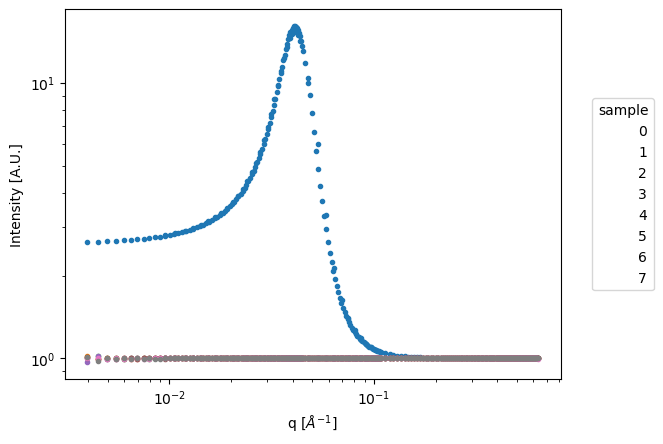

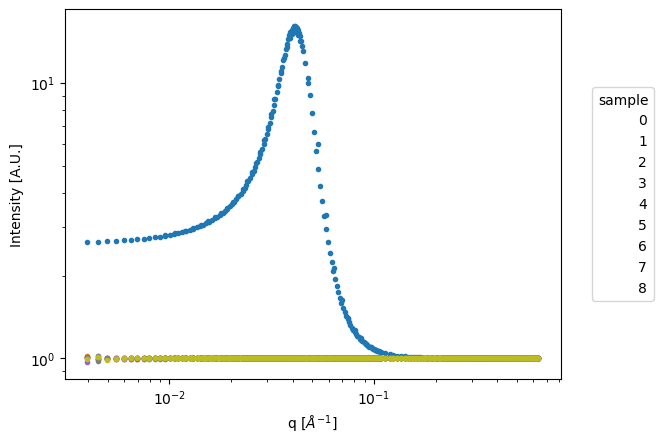

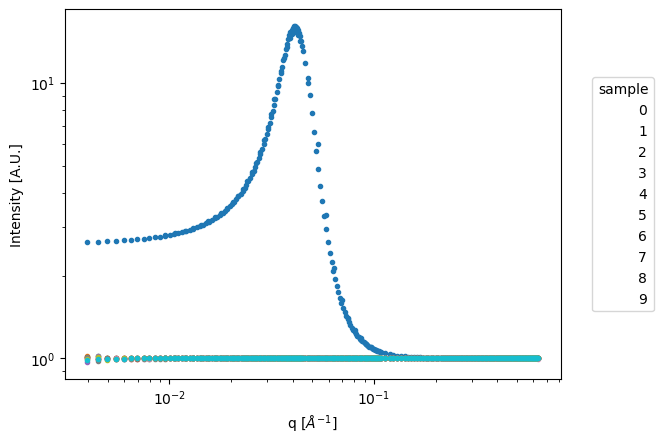

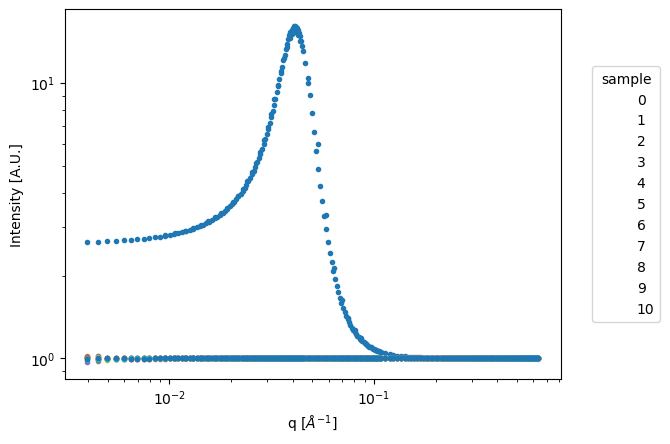

In [112]:
for result in results:
    plt.figure()
    result.sas.afl.scatt.plot_loglog()